# Case Study for predicting the attrition rate

## 1. Load the libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [2]:
hr = pd.read_csv('HR.csv')

## 2. EDA

In [3]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### 2.1 Missing Values

In [5]:
null_feat = pd.DataFrame(len(hr['left']) - hr.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### 2.2 Target Distribution

In [6]:
left = hr[(hr['left'] == 1)]
no_left = hr[(hr['left'] == 0)]

#------------COUNT-----------------------
trace = go.Bar(x = (len(left), len(no_left)), y = ['Left', 'Still_Employed'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of left variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['Left', 'Still_Employed'], values = hr['left'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of left variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### 2.3 Independent Variables Correlation Analysis

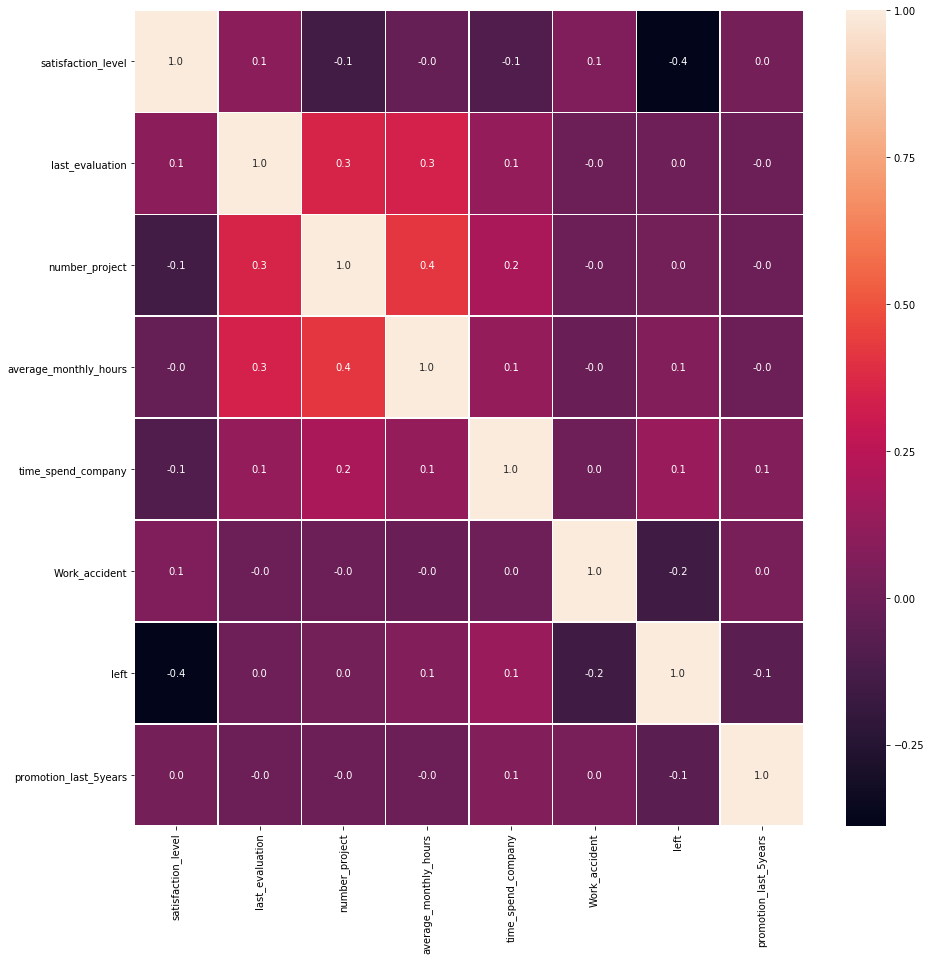

In [7]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(hr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [8]:
# create bins for hours
bins=[0,100,120,140,160,180,200,220,240,260,280,300,320]
hr['hoursbin']=pd.cut(hr['average_monthly_hours'],bins)
hr['hoursbin'].value_counts()

(140, 160]    2484
(240, 260]    2064
(220, 240]    1759
(160, 180]    1644
(260, 280]    1582
(180, 200]    1540
(200, 220]    1508
(120, 140]    1457
(280, 300]     403
(100, 120]     326
(300, 320]     159
(0, 100]        73
Name: hoursbin, dtype: int64

In [9]:
hr['hoursbin'] = hr['hoursbin'].astype("str")
hr.head()
type(hr['hoursbin'][1])

str

In [10]:
hr['hoursbin'].value_counts().sort_values()

(0, 100]        73
(300, 320]     159
(100, 120]     326
(280, 300]     403
(120, 140]    1457
(200, 220]    1508
(180, 200]    1540
(260, 280]    1582
(160, 180]    1644
(220, 240]    1759
(240, 260]    2064
(140, 160]    2484
Name: hoursbin, dtype: int64

### 2.4 Features Distribution and Barplot

In [11]:
def barplot(var_select) :
    
    tmp1 = pd.DataFrame(pd.crosstab(hr[var_select],hr['left']), )
    tmp1['left%'] = tmp1[1] / (tmp1[1] + tmp1[0]) * 100

    color=['lightskyblue','gold' ]
    
    trace1 = go.Bar(
        x=tmp1.index,
        y=tmp1[1],
        name='Left',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp1.index,
        y=tmp1[0],
        name='Still_Employed', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp1.index,
        y=tmp1['left%'],
        yaxis = 'y2',
        name='% Left', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 105], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% Left'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [12]:
barplot('satisfaction_level')
barplot('last_evaluation')
barplot('number_project')
barplot('hoursbin')
barplot('time_spend_company')
barplot('Work_accident')
barplot('promotion_last_5years')
barplot('department')
barplot('salary')

## 3. Building Model

In [13]:
cat_data=hr.select_dtypes(include='object')
a = list(cat_data)
for i in range(len(a)):
        hr = pd.get_dummies(hr, columns = [a[i]])

In [14]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,...,"hoursbin_(120, 140]","hoursbin_(140, 160]","hoursbin_(160, 180]","hoursbin_(180, 200]","hoursbin_(200, 220]","hoursbin_(220, 240]","hoursbin_(240, 260]","hoursbin_(260, 280]","hoursbin_(280, 300]","hoursbin_(300, 320]"
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
#split train and test set
from sklearn.model_selection import train_test_split
train, test =train_test_split(hr, test_size = 0.2)

In [17]:
#KNN
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.metrics import accuracy_score, recall_score, f1_score
X_train = train.drop('left',axis=1, inplace=False)
Y_train = train['left']
X_test = test.drop('left',axis=1, inplace=False)
Y_test = test['left']

model = kNN(n_neighbors = 3, algorithm='auto', weights='distance')
model.fit(X_train,Y_train)

y_pred = model.predict(X_test)

print('KNN')
print('acc:', accuracy_score(Y_test, y_pred))
print('rec:', recall_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred))

KNN
acc: 0.9506666666666667
rec: 0.9565807327001357
F1: 0.9050064184852374


In [19]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C = 100, class_weight = 'balanced', max_iter = 1000)
model.fit(X_train,Y_train)

Y_score = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Logistic Regression')
print('acc:', accuracy_score(Y_test, y_pred))
print('rec:', recall_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred))

Logistic Regression
acc: 0.8116666666666666
rec: 0.864314789687924
F1: 0.6927678085916259


/Users/dataapplicationlabdsta/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [20]:
#ROC Curve function definition 
from sklearn.metrics import roc_auc_score, roc_curve
def roccurve():
    model_roc_auc = round(roc_auc_score(Y_test, Y_score),3)
    fpr, tpr, t = roc_curve(Y_test, Y_score)
    trace4 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace5 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

    layout = go.Layout(title = str("ROC Curve"+" "+'('+str(model_roc_auc)+')'),
                   xaxis = dict(title = 'false positive rate'),
                   yaxis = dict(title = 'true positive rate'))
    fig = go.Figure(data=[trace4, trace5], layout= layout)
    py.iplot(fig)

In [21]:
roccurve()

In [22]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train,Y_train)

Y_score = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Decision Tree')
print('acc:', accuracy_score(Y_test, y_pred))
print('rec:', recall_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred))

roccurve()

Decision Tree
acc: 0.9773333333333334
rec: 0.9674355495251018
F1: 0.9544846050870147


In [23]:
#SVM
from sklearn.svm import SVC

model = SVC(C = 10, probability = True)
model.fit(X_train,Y_train)

Y_score = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('SVM')
print('acc:', accuracy_score(Y_test, y_pred))
print('rec:', recall_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred))

roccurve()

/Users/dataapplicationlabdsta/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVM
acc: 0.9633333333333334
rec: 0.926729986431479
F1: 0.9254742547425475


In [24]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,Y_train)

Y_score = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Random Forest')
print('acc:', accuracy_score(Y_test, y_pred))
print('rec:', recall_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred))

roccurve()

/Users/dataapplicationlabdsta/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Random Forest
acc: 0.9863333333333333
rec: 0.9565807327001357
F1: 0.9717436250861475
